In [ ]:
import os
import numpy as np
import librosa
import zipfile
import matplotlib.pyplot as plt
from google.colab import drive
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Mount Google Drive
# drive.mount('/content/drive')

# Define the path to your ZIP file and the extraction directory
zip_path = '/content/drive/MyDrive/Data/Savee_updated.zip'
extract_to = '/content/Savee_updated/Savee_updated'

# Function to extract zip files
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_path} to {extract_to}")

# Extract the ZIP file
extract_zip(zip_path, extract_to)

# Define the path to the extracted dataset
audio_data_dir = os.path.join(extract_to, 'ALL')

# Define emotion labels
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

Extracted /content/drive/MyDrive/Data/Savee_updated.zip to /content/Savee_updated/Savee_updated


In [ ]:
# Function to load and preprocess audio files
def load_audio_files(data_dir, emotion_labels):
    audio_features = []
    labels = []

    for emotion, label in emotion_labels.items():
        emotion_dir = os.path.join(data_dir, emotion)
        if not os.path.isdir(emotion_dir):
            print(f"Directory {emotion_dir} does not exist.")
            continue

        for audio_name in os.listdir(emotion_dir):
            if audio_name.endswith('.wav'):
                audio_path = os.path.join(emotion_dir, audio_name)
                try:
                    y, sr = librosa.load(audio_path, sr=None)
                    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                    mfccs = np.mean(mfccs.T, axis=0)
                    audio_features.append(mfccs)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {audio_path}: {e}")

    audio_features = np.array(audio_features)
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(emotion_labels))

    print(f"Loaded {len(audio_features)} audio files.")
    return audio_features, labels

In [ ]:
# Load audio data
x_audio_data, y_audio_data = load_audio_files(audio_data_dir, emotion_labels)

# Check if data is loaded correctly
if x_audio_data.size == 0 or y_audio_data.size == 0:
    print("No audio data found. Please check your dataset path and structure.")
else:
    # Split the data
    x_train_audio, x_test_audio, y_train_audio, y_test_audio = train_test_split(x_audio_data, y_audio_data, test_size=0.2, random_state=42)


Loaded 480 audio files.


In [ ]:
 # Create a simple neural network model
model = Sequential()
model.add(Dense(512, input_shape=(x_train_audio.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(emotion_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
 # Train the model
history = model.fit(x_train_audio, y_train_audio, epochs=100, batch_size=32, validation_data=(x_test_audio, y_test_audio))

Epoch 1/100
12/12 [==============================] - 1s 41ms/step - loss: 38.2424 - accuracy: 0.1667 - val_loss: 11.5864 - val_accuracy: 0.1042
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 21.0223 - accuracy: 0.1771 - val_loss: 4.5077 - val_accuracy: 0.0938
Epoch 3/100
12/12 [==============================] - 0s 21ms/step - loss: 14.7688 - accuracy: 0.1406 - val_loss: 2.6685 - val_accuracy: 0.1562
Epoch 4/100
12/12 [==============================] - 0s 22ms/step - loss: 9.8662 - accuracy: 0.1302 - val_loss: 2.2658 - val_accuracy: 0.1979
Epoch 5/100
12/12 [==============================] - 1s 57ms/step - loss: 6.1885 - accuracy: 0.1745 - val_loss: 1.9474 - val_accuracy: 0.1458
Epoch 6/100
12/12 [==============================] - 1s 54ms/step - loss: 4.4883 - accuracy: 0.1693 - val_loss: 1.9470 - val_accuracy: 0.1458
Epoch 7/100
12/12 [==============================] - 1s 49ms/step - loss: 3.8370 - accuracy: 0.1406 - val_loss: 1.9461 - val_accuracy: 0.1458
Ep

3/3 [==============================] - 0s 8ms/step - loss: 1.6634 - accuracy: 0.2812
Test Loss: 1.663446068763733
Test Accuracy: 0.28125


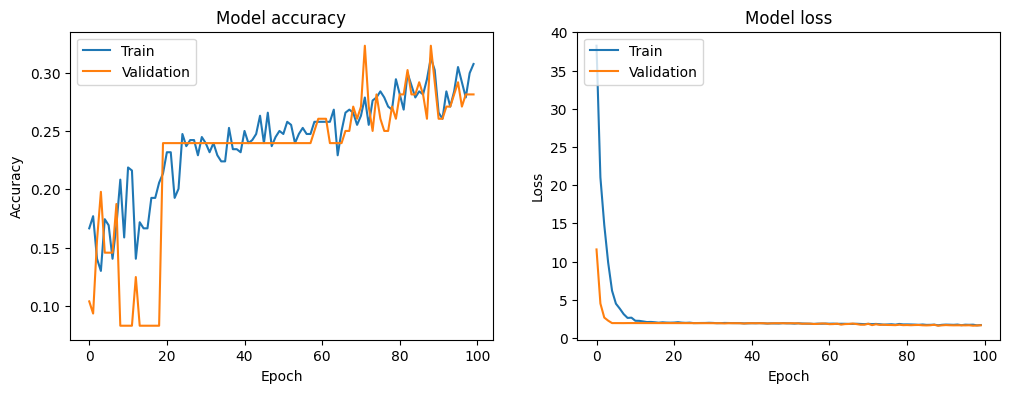

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test_audio, y_test_audio)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
import numpy as np
import librosa

def extract_features(data, sample_rate):
    result = np.array([])

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

def get_features(path):
    # Load audio file
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # Data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    # Data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))

    return result
